In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
path = "LogiReg_data.txt"
pdData = pd.read_table(path, header=None, sep=',',names=['Exam1', 'Exam2', 'Admitted'])
pdData.head()

,Exam1,Exam2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
pdData.shape

(100, 3)

In [4]:
pdData.describe()

,Exam1,Exam2,Admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


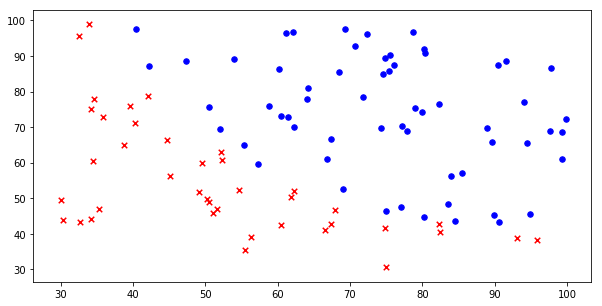

In [5]:
positive = pdData[pdData["Admitted"]==1]
negative = pdData[pdData["Admitted"]==0]

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(positive['Exam1'], positive['Exam2'], s=30, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam1'], negative['Exam2'], s=30, c='r', marker='x', label='Not Admitted')

# The Logistic Regression

* 目标:建立分类器(求解三个参数θ1,θ2,θ3)
* 设立阙值:根据阙值判断录取结果

## 要完成的模块

* sigmod:映射到概率的函数
* model:返回预测结果值
* cost:更具参数计算损失
* gradient:计算每个参数的梯度方向
* descent:进行参数更新
* accuracy:计算精度

In [6]:
def sigmod(z):
    return 1 / (1 + np.exp(-z))

In [7]:
def model(X, theta):
    return sigmod(np.dot(X, theta.T))

In [8]:
pdData.insert(0, 'ones', 1)

In [9]:
orig_data = pdData.as_matrix()
cols = orig_data.shape[1]
X = orig_data[:, 0:cols-1]
y = orig_data[:, cols-1:cols]
theta = np.zeros([1, 3])

In [10]:
X[:5]

array([[ 1.        , 34.62365962, 78.02469282],
       [ 1.        , 30.28671077, 43.89499752],
       [ 1.        , 35.84740877, 72.90219803],
       [ 1.        , 60.18259939, 86.3085521 ],
       [ 1.        , 79.03273605, 75.34437644]])

In [11]:
theta

array([[0., 0., 0.]])

In [12]:
X.shape, y.shape, theta.shape

((100, 3), (100, 1), (1, 3))

In [13]:
def cost(X, y, theta):
    left = np.multiply(-y, np.log(model(X, theta)))
    right = np.multiply(1-y, np.log(1 - model(X, theta)))
    return np.sum(left - right) / len(X)

In [14]:
cost(X, y, theta)

0.6931471805599453

## 计算梯度

In [15]:
def gradient(X, y, theta):
    grad = np.zeros(theta.shape)
    error = (model(X, theta) - y).ravel()
    for j in range(len(theta.ravel())):
        term = np.multiply(error, X[:,j])
        grad[0, j] = np.sum(term) / len(X)
    return grad

## Gradient descent

In [16]:
STOP_ITER = 0
STOP_COST = 1
STOP_GRAD = 2

def stopCriterion(type, value, threshold):
    # 设定三种不同的停止策略
    if type == STOP_ITER:
        return value > threshold
    if type == STOP_COST:
        return abs(value[-1] - value[-2]) < threshold
    if type == STOP_GRAD:
        return np.linalg.norm(value) < threshold

In [17]:
import numpy.random
# 洗牌
def shuffleDate(data):
    np.random.shuffle(data)
    X = data[:, :cols-1]
    y = data[:, cols-1:]
    return X, y

In [18]:
import time

def descent(data, theta, batchSize, stopType, thresh, alpha):
    # 梯度下降求解
    
    init_time = time.time()
    i = 0 # 迭代次数
    k = 0 # batch
    X, y = shuffleDate(data)
    grad = np.zeros(theta.shape) # 计算的梯度
    costs = [cost(X, y, theta)] # 损失值
    
    while True:
        grad = gradient(X[k:k+batchSize], y[k:k+batchSize], theta)
        k += batchSize # 取batch数量个数据
        if k >= n:
            k = 0
            X, y = shuffleDate(data) # 重新洗牌
        theta = theta - alpha*grad # 参数更新
        costs.append(cost(X, y, theta)) # 计算新的损失
        i += 1
        if stopType == STOP_ITER:
            value = i
        elif stopType == STOP_COST:
            value = costs
        elif stopType == STOP_GRAD:
            value = grad
        if stopCriterion(stopType, value, thresh):
            break
        
    return theta, i-1, costs, grad, time.time() - init_time    

In [19]:
def runExpe(data, theta, batchSize, stopType, thresh, alpha):
    theta, iter, costs, grad, dur = descent(data, theta, batchSize, stopType, thresh, alpha)
    name = 'Original' if (data[:,1]>2).sum() > 1 else 'Scaled'
    name += "data - learning rate: {} -".format(alpha)
    if batchSize == n:
        strDescType = "Gradient"
    elif batchSize == 1:
        strDescType = "Stochastic"
    else:
        strDescType = "Mini-batch {}".format(batchSize)
    name += strDescType + "descent - Stop"
    if stopType == n:
        strStop = "{} iterations".format(thresh)
    elif stopType == 1:
        strStop = "cost change < {}".format(thresh)
    else:
        strStop = "gradient norm < {}".format(thresh)
    name += strStop
    print("***{}\nTheta: {} - Iter: {} - Last cost: {:03.2f} - Duration: {:03.2f}s".format(
    name,  theta, iter, costs[-1], dur))
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + '- Error vs Iterations')
    return theta

## 对比不同的停止策略
### 设定迭代次数

***Originaldata - learning rate: 1e-06 -Gradientdescent - Stopgradient norm < 5000
Theta: [[-0.00027127  0.00705232  0.00376711]] - Iter: 5000 - Last cost: 0.63 - Duration: 0.91s


array([[-0.00027127,  0.00705232,  0.00376711]])

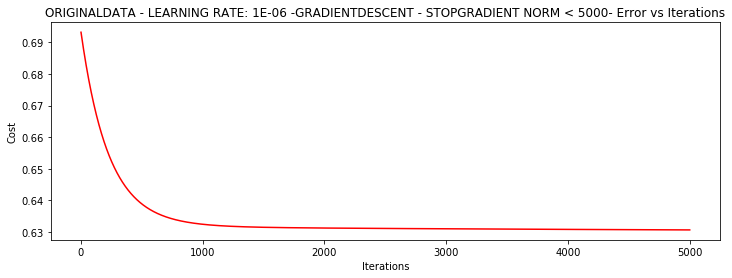

In [ ]:
# 选择梯度下降的方法是基于所有样本的
n = 100
runExpe(orig_data, theta, n, STOP_ITER, thresh=5000, alpha=0.000001)

### 根据损失值停止

设定阙值为1E-6,差不多需要110000次迭代

In [ ]:
# 使用设定损失值来停止
runExpe(orig_data, theta, n, STOP_COST, thresh=0.000001, alpha=0.001)

### 根据梯度变化停止

设定阙值为0.05, 差不多要迭代40000次

In [ ]:
runExpe(orig_data, theta, n, STOP_GRAD, thresh=0.05, alpha=0.001)

### 对比不同的梯度下降方法

In [ ]:
runExpe(orig_data, theta, 1, STOP_ITER, thresh=5000, alpha=0.001)

不稳定,调节学习率

In [ ]:
runExpe(orig_data, theta, 1, STOP_ITER, thresh=5000, alpha=0.000001)

得到随机梯度下降的结果,改小学习率,效果变好

#### Mini-batch descent

In [ ]:
runExpe(orig_data, theta, 16, STOP_ITER, thresh=15000, alpha=0.001)

浮动较大,对数据进行标准化(对每个数据减去均值,再除以其方差)

In [ ]:
from sklearn import preprocessing as pp

scaled_data = orig_data.copy()
scaled_data[:, 1:3] = pp.scale(orig_data[:, 1:3])

runExpe(scaled_data, theta, n, STOP_ITER, thresh=5000, alpha=0.001)

结果浮动较大时,先对数据进行处理,处理好后原来只能收敛到0.63,现在收敛到0.38

In [ ]:
runExpe(scaled_data, theta, 1, STOP_GRAD, thresh=0.02, alpha=0.001)

In [ ]:
runExpe(scaled_data, theta, 16, STOP_GRAD, thresh=0.002*2, alpha=0.001)

对数据进行预处理后,对比各种梯度下降方法的结果,可以看出对于本次训练数据mini-batch效果比较好

### 精度

In [40]:
# 设定阙值
def predict(X, theta):
    return [1 if x >= 0.5 else 0 for x in model(X, theta)]

In [41]:
scaled_X = scaled_data[:, :3]
y = scaled_data[:, 3]
predictions = predict(scaled_X, theta)
correct = [1 if ((a==1 and b==1) or (a==0 and b==0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print("accuracy = {0}%".format(accuracy))

accuracy = 60%
